In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint, odeint_adjoint

In [12]:
def plot_data(data):
    plt.figure(figsize=(10, 6))
    plt.plot(data['Time'], data['Glucose'], label='Glucose', color='blue', marker='o')
    plt.plot(data['Time'], data['Biomass'], label='Biomass', color='green', marker='o')
    plt.plot(data['Time'], data['Protein'], label='Protein', color='red', marker='o')
    plt.legend()
    plt.show()

Iter 0, Loss 149.04931640625
Iter 10, Loss 5.785817623138428
Iter 20, Loss 4.661364555358887
Iter 30, Loss 4.824982643127441
Iter 40, Loss 3.837043285369873
Iter 50, Loss 3.564241647720337
Iter 60, Loss 4.074267864227295
Iter 70, Loss 3.3141000270843506
Iter 80, Loss 3.2326014041900635
Iter 90, Loss 3.563077449798584
Iter 100, Loss 3.007291078567505


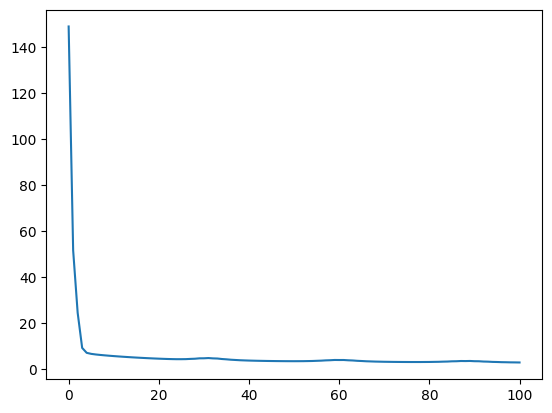

In [26]:
#  Read BR data
data = pd.read_excel('../Bioindustry/data/BR02_for_model.xlsx', header=0).drop(0, axis=0)
t_start = data['Time'].iloc[0]
t_end = data['Time'].iloc[-1]
t_span = [t_start, t_end]

# plot_data(data)
t = torch.tensor(data['Time'].values.astype(np.float32))
y_0 = torch.tensor([data['Glucose'].iloc[0], data['Biomass'].iloc[0], data['Protein'].iloc[0]])
y_true = torch.tensor(data[['Glucose', 'Biomass', 'Protein']].values.astype(np.float32))

# NODE
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 3)
        )

    def forward(self, t, y):
        return self.net(y)
    
n_iters = 100
func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=0.0005)
criterion = nn.MSELoss()

LOSS = []
for iter in range(n_iters+1):
    optimizer.zero_grad()
    y_pred = odeint_adjoint(func, y0=y_0, t=t, method='dopri5')
    loss = criterion(y_pred, y_true)
    LOSS.append(loss.item())
    loss.backward()
    optimizer.step()
    
    if iter % 10 == 0:
        print(f'Iter {iter}, Loss {loss.item()}')
        
plt.plot(LOSS)
plt.show()

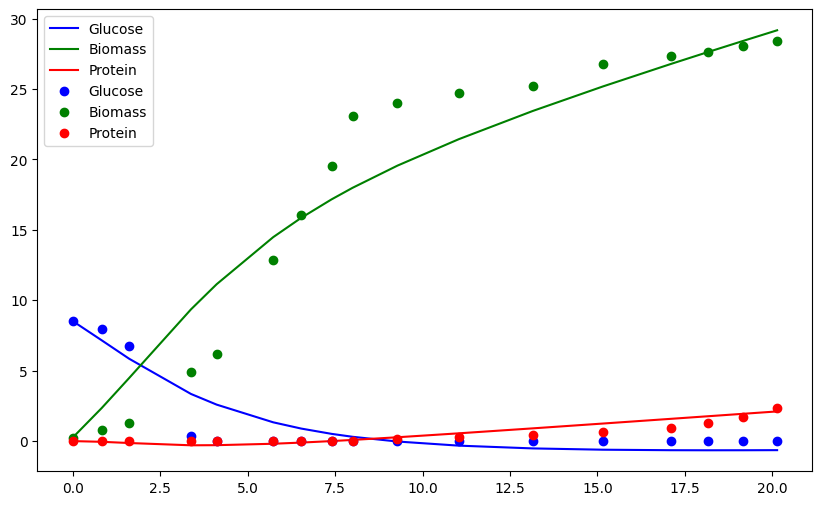

In [28]:
# Plot
y_pred = odeint(func, y0=y_0, t=t, method='dopri5')
plt.figure(figsize=(10, 6))
plt.plot(t.detach().numpy(), y_pred[:, 0].detach().numpy(), label='Glucose', color='blue')
plt.plot(t.detach().numpy(), y_pred[:, 1].detach().numpy(), label='Biomass', color='green')
plt.plot(t.detach().numpy(), y_pred[:, 2].detach().numpy(), label='Protein', color='red')
plt.plot(data['Time'], data['Glucose'], label='Glucose', color='blue', marker='o', linestyle='None')
plt.plot(data['Time'], data['Biomass'], label='Biomass', color='green', marker='o', linestyle='None')
plt.plot(data['Time'], data['Protein'], label='Protein', color='red', marker='o', linestyle='None')
plt.legend()
plt.show()

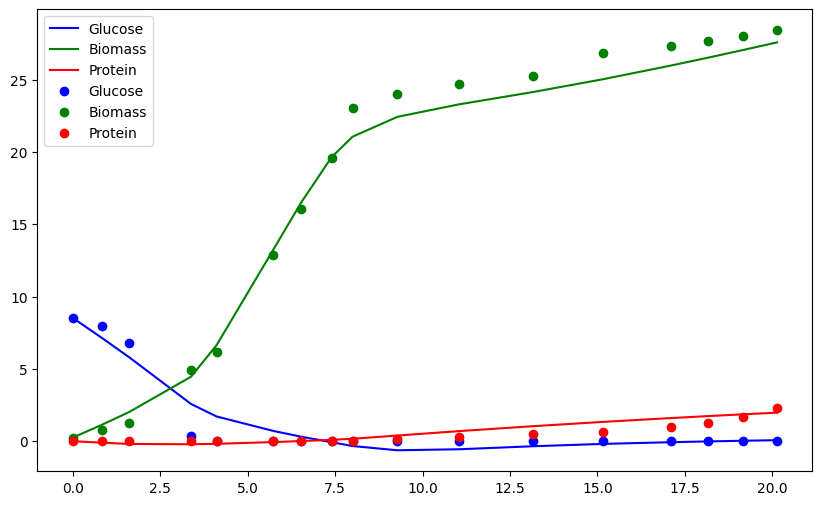